# Develop an ensemble model with StackingClassifier

In this notebook, we are developing and tuning a StackingClassifier based on three selected best performing models.

First, we load required modules and data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [3]:
data = pd.read_csv("../02_data_preparation/yoghurt_w_dummy_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21251 entries, 0 to 21250
Data columns (total 67 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 21251 non-null  int64  
 1   first_purchase             21251 non-null  bool   
 2   shelf_price                21251 non-null  float64
 3   pct_disc                   21251 non-null  float64
 4   pct_retail_disc            21251 non-null  float64
 5   pct_coupon_disc            21251 non-null  float64
 6   display_1                  21251 non-null  int64  
 7   display_2                  21251 non-null  int64  
 8   display_3                  21251 non-null  int64  
 9   display_4                  21251 non-null  int64  
 10  display_5                  21251 non-null  int64  
 11  display_6                  21251 non-null  int64  
 12  display_7                  21251 non-null  int64  
 13  display_9                  21251 non-null  int

In [4]:
data.drop(labels=["Unnamed: 0", "display_1", "display_5", "display_A", "campaign_6.0", "campaign_30.0", "description_TypeC"],
          axis = 1, inplace = True)

In [5]:
pd.set_option("display.max_columns", None)
data.describe(include = "all")

,first_purchase,shelf_price,pct_disc,pct_retail_disc,pct_coupon_disc,display_2,display_3,display_4,display_6,display_7,display_9,mailer_A,mailer_C,mailer_D,mailer_H,mailer_J,marital_status_A,marital_status_B,homeowner_Homeowner,homeowner_Probable Owner,homeowner_Probable Renter,homeowner_Renter,hhcomp_1 Adult Kids,hhcomp_2 Adults Kids,hhcomp_2 Adults No Kids,hhcomp_Single Female,hhcomp_Single Male,kid_category_1,kid_category_2,kid_category_3+,kid_category_None/Unknown,age_19-24,age_25-34,age_35-44,age_45-54,age_55-64,age_65+,income_100-124K,income_125-149K,income_15-24K,income_150-174K,income_175-199K,income_200-249K,income_25-34K,income_250K+,income_35-49K,income_50-74K,income_75-99K,income_Under 15K,hhsize_1,hhsize_2,hhsize_3,hhsize_4,hhsize_5+,campaign_8.0,campaign_13.0,campaign_18.0,campaign_29.0,description_TypeA,description_TypeB
count,21251,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.00000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000,21251.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,14083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.156933,0.158316,0.153330,0.004987,0.011152,0.007623,0.001082,0.005459,0.012046,0.004047,0.148699,0.001223,0.048751,0.008235,0.005270,0.488918,0.125406,0.686321,0.015152,0.005176,0.037834,0.061974,0.295092,0.314009,0.147711,0.122677,0.159240,0.098537,0.102254,0.63997,0.042727,0.211896,0.276975,0.347701,0.067009,0.053692,0.080420,0.074820,0.054586,0.085972,0.017646,0.006870,0.079384,0.017646,0.180086,0.224037,0.126394,0.052139,0.280975,0.374476,0.156746,0.089596,0.098207,0.076373,0.077879,0.075855,0.006776,0.230248,0.006776
std,NaN,1.104681,0.145841,0.137543,0.044610,0.105017,0.086979,0.032881,0.073682,0.109096,0.063488,0.355800,0.034958,0.215351,0.090374,0.072407,0.499889,0.331186,0.463999,0.122161,0.071761,0.190798,0.241113,0.456095,0.464131,0.354821,0.328073,0.365908,0.298046,0.302989,0.48002,0.202247,0.408661,0.447515,0.476252,0.250043,0.225413,0.271948,0.263107,0.227175,0.280330,0.131665,0.082604,0.270344,0.131665,0.384268,0.416956,0.332301,0.222312,0.449486,0.483999,0.363569,0.285609,0.297602,0.265600,0.267987,0.264773,0.082040,0.421001,0.082040
min,NaN,0.350000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.400000,0.

In [6]:
X = data.drop("first_purchase", axis = 1)
y = data["first_purchase"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, stratify = y)

In [8]:
cv = StratifiedShuffleSplit(n_splits = 5) 

In [9]:
from metrics import cross_val_scores, test_scores, train_scores

## Three input models

The two overall best-performing models rf_3 and xgb_2 are selected.
Additionally, lgbm_unbalanced was selected due to its high f1 score which is only slightly behind the corresponding weighted LightGBM model and clearly best among the models without weighting and higher precision than recall. 
Fix random state in order to facilitate model comparison during tuning.

In [10]:
estimators = [
    ("rf_3", RandomForestClassifier(n_jobs = -1, class_weight = "balanced",
                             max_depth = 20, max_samples = 0.7, min_samples_split = 6, n_estimators = 250, random_state = 42)),
    ("xgb_2", xgb.XGBClassifier(scale_pos_weight = 1.965, colsample_bytree = 0.6, colsample_bynode = 0.8, colsample_bylevel = 0.5, 
                                max_delta_step = 1, tree_method = "hist", objective = "binary:logistic",
                         alpha = 1, reg_lambda = 2, learning_rate = 0.2, max_depth = 14, min_child_weight = 3,
                         n_estimators = 300, subsample = 0.8, random_state = 42)),
    ("lgbm_unbalanced", lgb.LGBMClassifier(objective = "binary", max_depth = 9, 
                                      boosting_type = 'gbdt', colsample_bytree = 0.8, learning_rate= 0.5,  max_bin= 40, 
                                      min_child_samples= 50,  n_estimators= 400, num_leaves= 70,  reg_alpha= 0, random_state =42))]

## Fitting initial StackingClassifier

In [11]:
stacked = StackingClassifier(estimators = estimators, n_jobs = -1, final_estimator = lgb.LGBMClassifier(), cv=5, passthrough=True)

In [12]:
stacked.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf_3',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=20,
                                                       max_samples=0.7,
                                                       min_samples_split=6,
                                                       n_estimators=250,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('xgb_2',
                                XGBClassifier(alpha=1, base_score=None,
                                              booster=None, callbacks=None,
                                              colsample_bylevel=0.5,
                                              colsample_bynode=0.8,
                                              colsample_bytree=0.6,
                               

In [13]:
test_scores(stacked, X_test, y_test)

0.6362608367885413
0.6923707957342083
0.5885634588563459
0.772994589508351


## Tune hyperparameters of StackingClassifier with GridSearch

In [45]:
params_stack = {
    "final_estimator": [RandomForestClassifier(), xgb.XGBClassifier(), lgb.LGBMClassifier()],
    "stack_method": ["auto", "predict_proba", "decision_function", "predict"],
    "passthrough": [True, False]}

In [46]:
stack = StackingClassifier(estimators = estimators, n_jobs = -1, cv=5)

In [47]:
grid_search_stack = GridSearchCV(stack, param_grid= params_stack, cv=cv, scoring = "f1")
grid_search_stack.fit(X_train, y_train)

C:\Users\Gabriele\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Gabriele\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Gabriele\anaconda3\lib\site-packages\sklearn\ensemble\_stacking.py", line 488, in fit
    return super().fit(X, self._le.transform(y), sample_weight)
  File "C:\Users\Gabriele\anaconda3\lib\site-packages\sklearn\ensemble\_stacking.py", line 186, in fit
    self.stack_method_ = [
  File

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
             estimator=StackingClassifier(cv=5,
                                          estimators=[('rf_3',
                                                       RandomForestClassifier(class_weight='balanced',
                                                                              max_depth=20,
                                                                              max_samples=0.7,
                                                                              min_samples_split=6,
                                                                              n_estimators=250,
                                                                              n_jobs=-1,
                                                                              random_state=42)),
                                                      ('xgb_2',
                                      

In [48]:
grid_search_stack.best_score_

0.6280397471321921

In [49]:
grid_search_stack.best_params_

{'final_estimator': LGBMClassifier(),
 'passthrough': True,
 'stack_method': 'predict'}

In [50]:
grid_search_stack.cv_results_

{'mean_fit_time': array([29.83100224, 30.98059268,  7.43923335, 25.30708723, 24.30842547,
        24.00579295,  5.38668747, 22.96410975, 25.33087754, 25.34531069,
         5.30236573, 25.01552706, 22.80121984, 22.91519866,  5.08536558,
        22.31082268, 22.61065273, 23.9693172 ,  5.03726745, 22.38969045,
        22.6750392 , 23.75127268,  4.99346733, 22.3223074 ]),
 'std_fit_time': array([7.34443306, 6.05384301, 0.34662576, 2.44579711, 0.37186652,
        0.81525736, 0.39772301, 0.45923693, 0.61317523, 0.59878249,
        0.36802263, 0.47440913, 0.45091178, 0.51500986, 0.33807676,
        0.3298705 , 0.50926361, 1.83283974, 0.44769061, 0.24673653,
        0.47047251, 1.66013372, 0.26651812, 0.35443602]),
 'mean_score_time': array([0.31598868, 0.43737001, 0.        , 0.25416365, 0.2638206 ,
        0.24293365, 0.        , 0.22390308, 0.211128  , 0.21519918,
        0.        , 0.22015247, 0.22464981, 0.21791053, 0.        ,
        0.23178802, 0.24037099, 0.24566369, 0.        , 0.23

## Validate improved model based on Grid Search

In [14]:
stack_1 = StackingClassifier(estimators = estimators, n_jobs = -1, cv=5, 
                            final_estimator= lgb.LGBMClassifier(), passthrough = True, stack_method = "predict")

In [15]:
stack_1.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf_3',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=20,
                                                       max_samples=0.7,
                                                       min_samples_split=6,
                                                       n_estimators=250,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('xgb_2',
                                XGBClassifier(alpha=1, base_score=None,
                                              booster=None, callbacks=None,
                                              colsample_bylevel=0.5,
                                              colsample_bynode=0.8,
                                              colsample_bytree=0.6,
                               

In [16]:
test_scores(stack_1, X_test, y_test)

0.6428571428571428
0.6809672386895476
0.608786610878661
0.7718183956716067


Inspect learning and validation curves

In [16]:
from plotting import plot_learning_curve, plot_validation_curve

Good news - learning curve looks better. Training score does not drop anymore with increasing data size, though still overfitting.

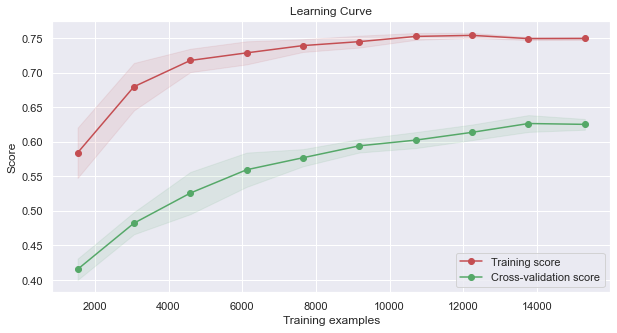

In [57]:
learning_curve = plot_learning_curve(stack_1, X_train, y_train, cv = cv,  
                          train_sizes = np.linspace(.1, 1, 10), scoring = "f1")          

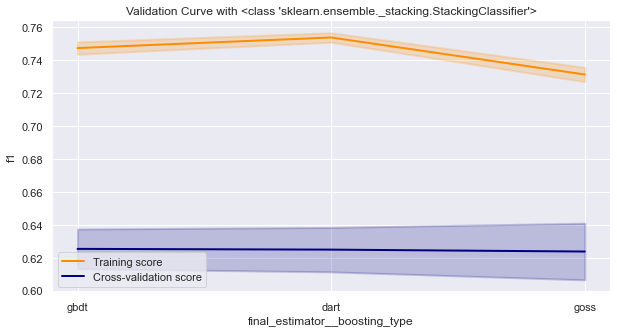

In [58]:
val_boosting_type = plot_validation_curve(stack_1, X_train, y_train, cv = cv, 
                                      param_name ="final_estimator__boosting_type", param_range = ["gbdt", "dart", "goss"], scoring = "f1")

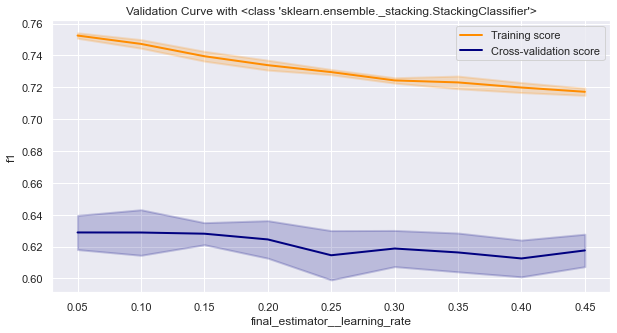

In [59]:
val_learning_rate = plot_validation_curve(stack_1, X_train, y_train, cv=cv,
                                              param_name = "final_estimator__learning_rate", param_range = np.arange(0.05,0.5,0.05), scoring="f1")

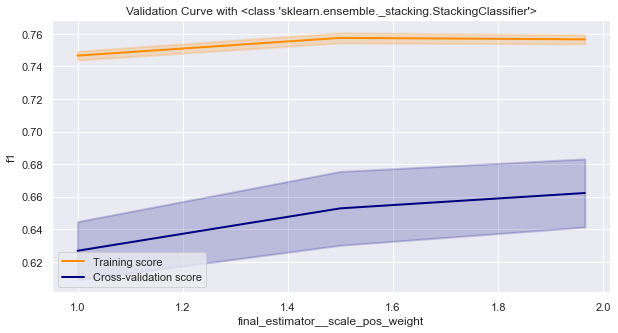

In [60]:
val_scale_pos_weight = plot_validation_curve(stack_1, X_train, y_train, cv=cv,
                                              param_name = "final_estimator__scale_pos_weight", param_range = [1, 1.5, 1.965], scoring="f1")

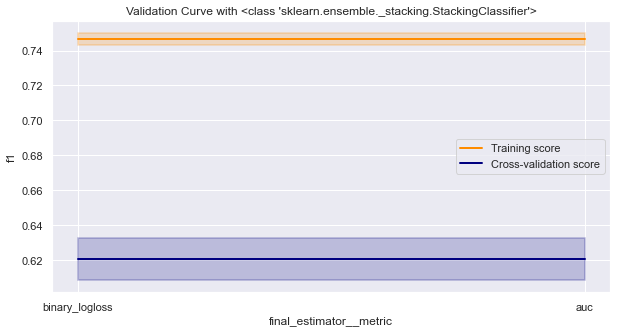

In [61]:
val_metric = plot_validation_curve(stack_1, X_train, y_train, cv=cv,
                                              param_name = "final_estimator__metric", param_range = ["binary_logloss", "auc"], scoring="f1")

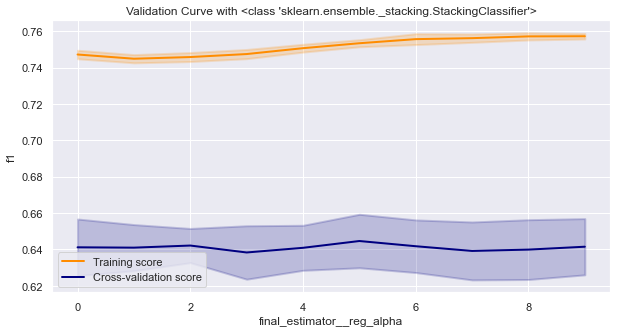

In [62]:
val_lambda_l1 = plot_validation_curve(stack_1, X_train, y_train, cv=cv,
                                              param_name = "final_estimator__reg_alpha", param_range = np.arange(0,10,1), scoring="f1")

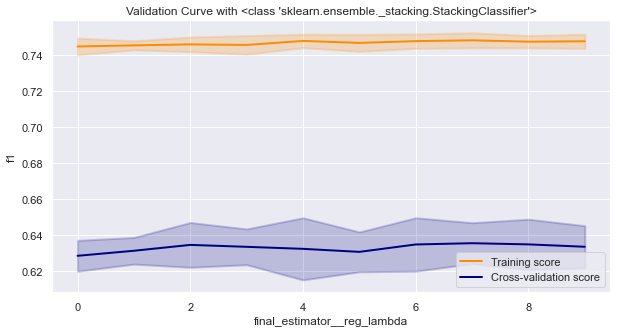

In [63]:
val_lambda_l2 = plot_validation_curve(stack_1, X_train, y_train, cv=cv,
                                              param_name = "final_estimator__reg_lambda", param_range = np.arange(0,10,1), scoring="f1")

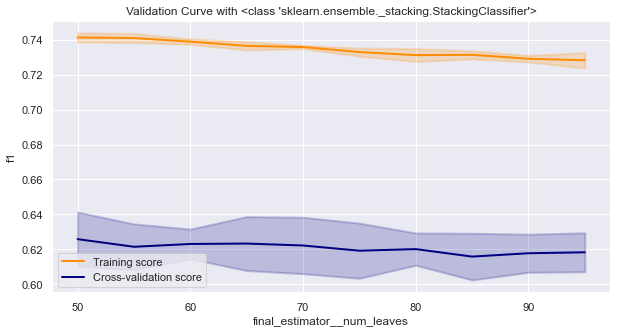

In [64]:
val_num_leaves = plot_validation_curve(stack_1, X_train, y_train, cv=cv,
                                              param_name = "final_estimator__num_leaves", param_range = np.arange(50,100, 5), scoring="f1")

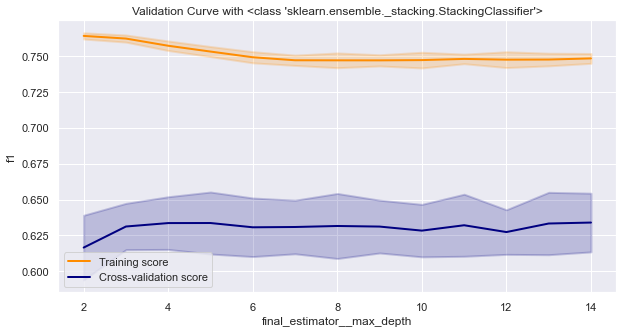

In [65]:
val_max_depth = plot_validation_curve(stack_1, X_train, y_train, cv=cv,
                                              param_name = "final_estimator__max_depth", param_range = np.arange(2,15,1), scoring="f1")

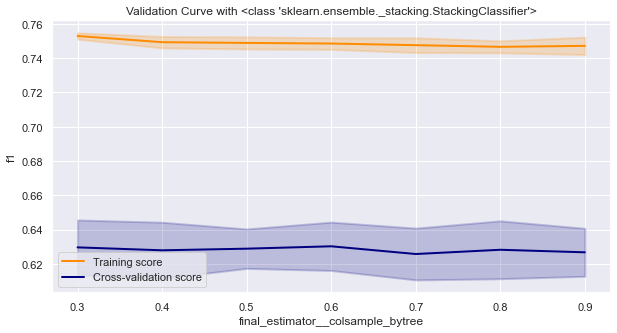

In [66]:
val_colsample_bytree = plot_validation_curve(stack_1, X_train, y_train, cv=cv,
                                              param_name = "final_estimator__colsample_bytree", param_range = np.arange(0.3, 1, 0.1), scoring="f1")

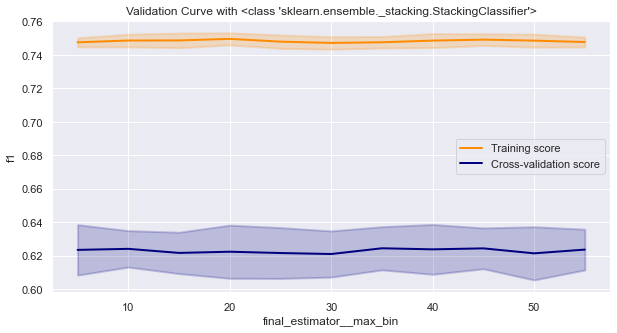

In [67]:
val_max_bin = plot_validation_curve(stack_1, X_train, y_train, cv=cv,
                                              param_name = "final_estimator__max_bin", param_range = np.arange(5, 60, 5), scoring="f1")

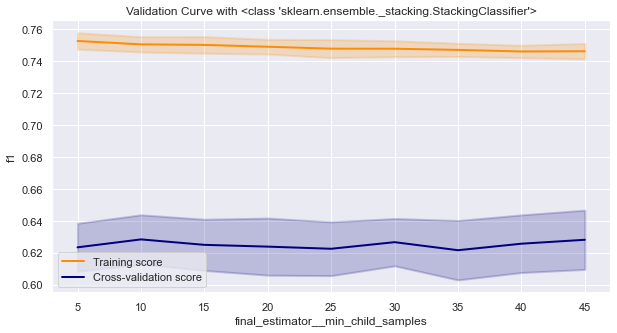

In [69]:
val_min_child_samples = plot_validation_curve(stack_1, X_train, y_train, cv=cv,
                                              param_name = "final_estimator__min_child_samples", param_range = np.arange(5, 50, 5), scoring="f1")

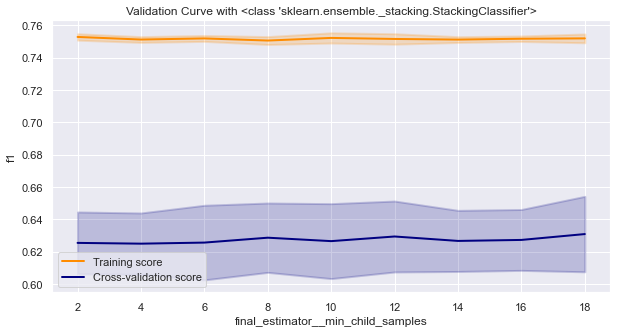

In [73]:
val_min_child_samples = plot_validation_curve(stack_1, X_train, y_train, cv=cv,
                                              param_name = "final_estimator__min_child_samples", param_range = np.arange(2, 20, 2), scoring="f1")

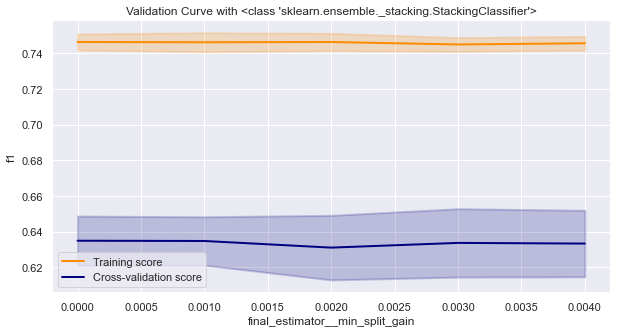

In [71]:
val_min_split_gain = plot_validation_curve(stack_1, X_train, y_train, cv=cv,
                                              param_name = "final_estimator__min_split_gain", param_range = np.arange(0, 0.005, 0.001), scoring="f1")

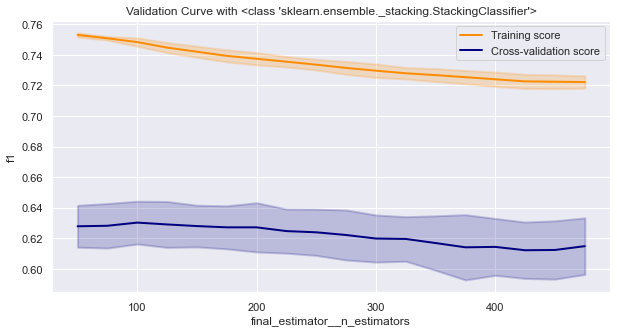

In [72]:
val_n_estimators = plot_validation_curve(stack_1, X_train, y_train, cv=cv,
                                              param_name = "final_estimator__n_estimators", param_range = np.arange(50, 500, 25), scoring="f1")

## Tune final estimator of StackingClassifier

In [10]:
stack_2 = StackingClassifier(estimators = estimators, n_jobs = -1, cv=5, 
                             final_estimator= lgb.LGBMClassifier(scale_pos_weight = 1.965), 
                             passthrough = True, stack_method = "predict")

In [11]:
grid_params_stack_2 = {
    "final_estimator__boosting_type": ["gbdt", "goss"], 
    "final_estimator__learning_rate": [0.1, 0.15],  
    "final_estimator__reg_alpha": [1, 2, 5], 
    "final_estimator__max_depth": [5, 11, 14], 
    "final_estimator__colsample_bytree": [0.6, 0.8],
    "final_estimator__max_bin": [35, 45], 
    "final_estimator__min_child_samples": [10, 12, 50], 
    "final_estimator__n_estimators": [100, 200]}    

In [12]:
grid_search_stack_2 = GridSearchCV(stack_2, param_grid = grid_params_stack_2, scoring = "f1", cv = cv)
grid_search_stack_2.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=None,
            train_size=None),
             estimator=StackingClassifier(cv=5,
                                          estimators=[('rf_3',
                                                       RandomForestClassifier(class_weight='balanced',
                                                                              max_depth=20,
                                                                              max_samples=0.7,
                                                                              min_samples_split=6,
                                                                              n_estimators=250,
                                                                              n_jobs=-1,
                                                                              random_state=42)),
                                                      ('xgb_2',
                                                       XGBClassifier(alpha=1,
                                                                     base_score=None,
                                                                     booster=...
             param_grid={'final_estimator__boosting_type': ['gbdt', 'goss'],
                         'final_estimator__colsample_bytree': [0.6, 0.8],
                         'final_estimator__learning_rate': [0.1, 0.15],
                         'final_estimator__max_bin': [35, 45],
                         'final_estimator__max_depth': [5, 11, 14],
                         'final_estimator__min_child_samples': [10, 12, 50],
                         'final_estimator__n_estimators': [100, 200],
                         'final_estimator__reg_alpha': [1, 2, 5]},
             scoring='f1')

In [13]:
grid_search_stack_2.best_score_

0.6518146627983111

In [14]:
grid_search_stack_2.best_params_

{'final_estimator__boosting_type': 'goss',
 'final_estimator__colsample_bytree': 0.8,
 'final_estimator__learning_rate': 0.1,
 'final_estimator__max_bin': 45,
 'final_estimator__max_depth': 5,
 'final_estimator__min_child_samples': 10,
 'final_estimator__n_estimators': 100,
 'final_estimator__reg_alpha': 5}

In [15]:
grid_search_stack_2.cv_results_

{'mean_fit_time': array([6.82481599, 5.18793693, 5.14028211, 5.32723885, 5.41422019,
        5.41065788, 5.40039229, 5.29511485, 5.38611503, 5.46478148,
        5.36391296, 5.32912145, 5.35723791, 5.47353673, 5.4262311 ,
        5.56761227, 5.42624807, 5.57802691, 5.46819253, 5.50340672,
        5.61424775, 5.57400513, 5.65163889, 5.57767119, 5.55638661,
        5.56221094, 5.66735358, 5.53426099, 5.67338958, 5.57015448,
        5.53905206, 5.62253423, 5.46259589, 5.60476189, 5.61446648,
        5.69971695, 5.54466381, 5.57551465, 5.57021689, 5.70976901,
        5.68533425, 5.56860123, 5.45094342, 5.5664351 , 5.62572198,
        5.5906477 , 5.50630884, 5.5129241 , 5.61314731, 5.60306902,
        5.56647873, 5.60695701, 5.65612559, 5.64910712, 5.47270083,
        5.61509809, 5.52565103, 5.69035063, 5.63603172, 5.5789916 ,
        5.52064242, 5.6685926 , 5.59754047, 5.62129145, 5.54875298,
        5.61550822, 5.69897261, 5.56237993, 5.56160541, 5.63410454,
        5.65816669, 5.63148236,

## Define improved model 

In [17]:
stack_21 = StackingClassifier(estimators = estimators, n_jobs = -1, cv=5, 
                             final_estimator= lgb.LGBMClassifier(scale_pos_weight = 1.965, boosting_type = "goss", learning_rate = 0.1,
                                                                max_bin = 45, max_depth = 5, min_child_samples = 10,
                                                                n_estimators = 100, reg_alpha = 5), 
                             passthrough = True, stack_method = "predict")

In [18]:
stack_21.fit(X_train.values, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf_3',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=20,
                                                       max_samples=0.7,
                                                       min_samples_split=6,
                                                       n_estimators=250,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('xgb_2',
                                XGBClassifier(alpha=1, base_score=None,
                                              booster=None, callbacks=None,
                                              colsample_bylevel=0.5,
                                              colsample_bynode=0.8,
                                              colsample_bytree=0.6,
                               

In [19]:
test_scores(stack_21, X_test, y_test)

C:\Users\Gabriele\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.6574307304785895
0.5993111366245695
0.7280334728033473
0.7440602211244413


In [20]:
train_scores(stack_21, X_train, y_train)

C:\Users\Gabriele\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


0.7595791457286433
0.6908026278206226
0.8435647017788629
0.8198823529411765


## Run improved model with random state removed

In [10]:
estimators_no_rand = [
    ("rf_3", RandomForestClassifier(n_jobs = -1, class_weight = "balanced",
                             max_depth = 20, max_samples = 0.7, min_samples_split = 6, n_estimators = 250)),
    ("xgb_2", xgb.XGBClassifier(scale_pos_weight = 1.965, colsample_bytree = 0.6, colsample_bynode = 0.8, colsample_bylevel = 0.5, 
                                max_delta_step = 1, tree_method = "hist", objective = "binary:logistic",
                         alpha = 1, reg_lambda = 2, learning_rate = 0.2, max_depth = 14, min_child_weight = 3,
                         n_estimators = 300, subsample = 0.8)),
    ("lgbm_unbalanced", lgb.LGBMClassifier(objective = "binary", max_depth = 9, 
                                      boosting_type = 'gbdt', colsample_bytree = 0.8, learning_rate= 0.5,  max_bin= 40, 
                                      min_child_samples= 50,  n_estimators= 400, num_leaves= 70,  reg_alpha= 0))]

In [11]:
stack_21_no_rand = StackingClassifier(estimators = estimators_no_rand, n_jobs = -1, cv=5, 
                             final_estimator= lgb.LGBMClassifier(scale_pos_weight = 1.965, boosting_type = "goss", learning_rate = 0.1,
                                                                max_bin = 45, max_depth = 5, min_child_samples = 10,
                                                                n_estimators = 100, reg_alpha = 5), 
                             passthrough = True, stack_method = "predict")

In [12]:
stack_21_no_rand.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('rf_3',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=20,
                                                       max_samples=0.7,
                                                       min_samples_split=6,
                                                       n_estimators=250,
                                                       n_jobs=-1)),
                               ('xgb_2',
                                XGBClassifier(alpha=1, base_score=None,
                                              booster=None, callbacks=None,
                                              colsample_bylevel=0.5,
                                              colsample_bynode=0.8,
                                              colsample_bytree=0.6,
                                              early_stopping_rounds=None,
                             

In [13]:
test_scores(stack_21_no_rand, X_test, y_test)

0.6741363211951447
0.6087689713322091
0.7552301255230126
0.7537050105857446


In [14]:
train_scores(stack_21_no_rand, X_train, y_train)

0.7505491057420772
0.6820644425434844
0.834321590512731
0.8129411764705883


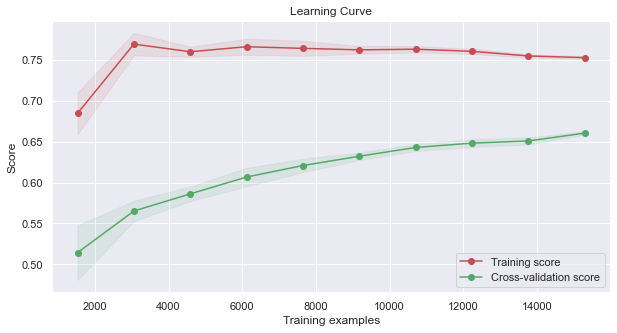

In [17]:
learning_curve = plot_learning_curve(stack_21_no_rand, X_train, y_train, cv = cv,  
                          train_sizes = np.linspace(.1, 1, 10), scoring = "f1")   